In [1]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import matplotlib.pyplot as plt
from datetime import datetime

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig

In [2]:
# -----parsing command line arguments-----#
parser = argparse.ArgumentParser(description='Training CNN model to predict STARR-seq enhancers based on chromatin accessbility and histone marks')
parser.add_argument('-s', '--starrseq', type=str, help='comma separated string of starrseq peak replicates')
parser.add_argument('-a', '--track1_peaks', type=str, help='chromatin accessibility peak')
parser.add_argument('-b', '--track2_peaks', type=str, help='ChIP-seq H3K27ac peak')
parser.add_argument('-c', '--track3_peaks', type=str, help='ChIP-seq H3K4me3 peak')
parser.add_argument('-d', '--track4_peaks', type=str, help='ChIP-seq H3K9ac peak')
parser.add_argument('-e', '--track5_peaks', type=str, help='ChIP-seq H3K4me1 peak')
parser.add_argument('-f', '--track1_bw', type=str, help='chromatin accessibility bigWig')
parser.add_argument('-g', '--track2_bw', type=str, help='ChIP-seq H3K27ac bigWig')
parser.add_argument('-i', '--track3_bw', type=str, help='ChIP-seq H3K4me3 bigWig')
parser.add_argument('-j', '--track4_bw', type=str, help='ChIP-seq H3K9ac bigWig')
parser.add_argument('-k', '--track5_bw', type=str, help='ChIP-seq H3K4me1 bigWig')
parser.add_argument('-o', '--out_dir', type=str, help='output_directory')
parser.add_argument('-x', '--cell_name', type=str, help='name of the cell')
parser.add_argument('-y', '--pos_neg_ratio', type=int, help='positive to negative ratio')
parser.add_argument('-z', '--window_size', type=int, help='prediction window size')

#temporary experiment in local directory
cell_type = os.environ['cell_type']
# cell_type = "A549"

#simulate command line input
stardir = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/starrpeaker_positive/raw/"
seqdir = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/"+cell_type+"/"
cmdline_str='-s ' + stardir + cell_type + '_r1_starrpeaker.peak.final.bed' + ',' + \
    stardir + cell_type+'_r2_starrpeaker.peak.final.bed' + \
    ' -a ' + seqdir+cell_type+".ATAC-seq.narrowPeak" + \
    ' -b ' + seqdir+cell_type+".ChIP-seq.H3K27ac.narrowPeak" + \
    ' -c ' + seqdir+cell_type+".ChIP-seq.H3K4me3.narrowPeak" + \
    ' -d ' + seqdir+cell_type+".ChIP-seq.H3K9ac.narrowPeak" + \
    ' -e ' + seqdir+cell_type+".ChIP-seq.H3K4me1.narrowPeak" + \
    ' -f ' + seqdir+cell_type+".ATAC-seq.bigWig" + \
    ' -g ' + seqdir+cell_type+".ChIP-seq.H3K27ac.bigWig" + \
    ' -i ' + seqdir+cell_type+".ChIP-seq.H3K4me3.bigWig" + \
    ' -j ' + seqdir+cell_type+".ChIP-seq.H3K9ac.bigWig" + \
    ' -k ' + seqdir+cell_type+".ChIP-seq.H3K4me1.bigWig" + \
    ' -o ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/encoded_1overlap/ATAC/" + \
    ' -x ' + cell_type + \
    ' -y ' + "1" + \
    ' -z ' + "4000"
#print(cmdline_str.split())

#check if the files are there
args = parser.parse_args(cmdline_str.split())
args.starrseq = args.starrseq.split(",")
for key, value in vars(args).items():
    #print(key, value)
    if type(value) is list:
        for v in value:
            if not os.path.exists(v):
                print(key + " argument file does not exist")
                exit(1)
    elif key == "out_dir" or key == "cell_name" or key == "pos_neg_ratio" or key == "window_size":
        continue
    else:
        if not os.path.exists(value):
                print(key + " argument file does not exist")
                exit(1)
print("all files found!")

#construct a set of autosome + X chromosome names
chromosomes = []
for i in range(1,23):
    chromosomes.append("chr"+str(i))
chromosomes.append("chrX")
print(chromosomes)

os.system("mkdir -p " + args.out_dir)

all files found!
['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


0

In [3]:
#-----IO and combine the raw STARR-seq replicate files-----#
if len(args.starrseq) == 1:
    s = pybedtools.BedTool(args.starrseq[0]).filter(lambda x: float(x[9]) > 1.30).sort().merge()
else:
    s1 = pybedtools.BedTool(args.starrseq[0]).filter(lambda x: float(x[9]) > 1.30).sort()
    s2 = pybedtools.BedTool(args.starrseq[1]).filter(lambda x: float(x[9]) > 1.30).sort()
    #s = s1.intersect(s2).filter(pybedtools.featurefuncs.greater_than, 300).sort().merge() #only 4000 positives
    s = s1.cat(s2).sort().merge().filter(pybedtools.featurefuncs.greater_than, 150).sort() #9000 positives
print(s.count())

89403


In [4]:
#-----IO and preprocess the signal files-----#
chromAcc = pybedtools.BedTool(args.track1_peaks).sort().merge()
chip1 = pybedtools.BedTool(args.track2_peaks).sort().merge()
chip2 = pybedtools.BedTool(args.track3_peaks).sort().merge()
chip3 = pybedtools.BedTool(args.track4_peaks).sort().merge()
chip4 = pybedtools.BedTool(args.track5_peaks).sort().merge()

#intersect combined STARR-seq peaks with chromatin accessibility, and filter for regions >150bp (TODO: might be to short)
starr_and_chromAcc = s.intersect(chromAcc, sorted=True,).filter(pybedtools.featurefuncs.greater_than, 150).sort()

#intersect STARR+chrom with H3K27ac, and filter for regions >150bp
starr_and_chip1 = s.intersect(chip1, sorted=True).filter(pybedtools.featurefuncs.greater_than, 150).sort()

#intersect STARR+chrom with H3K4me3, and filter for regions >150bp
starr_and_chip2 = s.intersect(chip2, sorted=True).filter(pybedtools.featurefuncs.greater_than, 150).sort()

#intersect STARR+chrom with H3K9ac, and filter for regions >150bp
starr_and_chip3 = s.intersect(chip3, sorted=True).filter(pybedtools.featurefuncs.greater_than, 150).sort()

#intersect STARR+chrom with H3K4me1, and filter for regions >150bp
starr_and_chip4 = s.intersect(chip4, sorted=True).filter(pybedtools.featurefuncs.greater_than, 150).sort()

#combined STARR+chrom+ChIP
catted_training = starr_and_chromAcc.cat(starr_and_chip1).cat(starr_and_chip2).cat(starr_and_chip3).cat(starr_and_chip4).filter(lambda x: x.chrom in chromosomes)

#center the overlapped regions and extend both sides up to half window size, making all regions uniformly window size 
positive_training = catted_training.each(pybedtools.featurefuncs.midpoint).slop(b=args.window_size/2, genome="hg38").filter(pybedtools.featurefuncs.greater_than, args.window_size-1).sort()

#report total number of peaks
print("total chrom peaks: " + str(chromAcc.count()))
print("total STARR+chrom peaks: " + str(starr_and_chromAcc.count()))
print("total peaks: " + str(positive_training.count()))
print((s-chromAcc).count())
print((chromAcc-s).count())

positive_training.saveas(args.out_dir + args.cell_name + ".positive.bed")

total chrom peaks: 67142
total STARR+chrom peaks: 11932
total peaks: 26986
77038
54365


<BedTool(/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/encoded_1overlap/ATAC/A549.positive.bed)>

In [5]:
#-----create negative samples-----#

#generate 2000bp of the entire genome
hg38_windows = pybedtools.BedTool().window_maker(genome="hg38", w=args.window_size).filter(pybedtools.featurefuncs.greater_than, args.window_size-1).filter(lambda x: x.chrom in chromosomes)

#remove ENCODE blacklist regions
if not os.path.exists('./hg38.blacklist.bed.gz'):
    url = 'http://mitra.stanford.edu/kundaje/akundaje/release/blacklists/hg38-human/hg38.blacklist.bed.gz'
    wget.download(url, './hg38.blacklist.bed.gz')
blacklist = pybedtools.BedTool('./hg38.blacklist.bed.gz')
hg38_windows = hg38_windows - blacklist

#remove STARR-seq regions
#hg38_windows = (hg38_windows - s)
hg38_windows = hg38_windows - positive_training
print("original negative window: " + str(hg38_windows.count()))

#downsample negative to 10x of positive
negative_training = hg38_windows.random_subset(positive_training.count() * 10).sort()
print("downsampled negative window: " + str(negative_training.count()))

negative_training.saveas(args.out_dir + args.cell_name + ".negative.bed")


original negative window: 709141
downsampled negative window: 269860


<BedTool(/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/encoded_1overlap/ATAC/A549.negative.bed)>

In [6]:
#IO the bigwig signals
chromAcc_bw = pyBigWig.open(args.track1_bw)
chip1_bw = pyBigWig.open(args.track2_bw)
chip2_bw = pyBigWig.open(args.track3_bw)
chip3_bw = pyBigWig.open(args.track4_bw)
chip4_bw = pyBigWig.open(args.track5_bw)

def bigWigAverageOverBed(x, bigwig):
    return bigwig.stats(x.chrom, x.start, x.stop, nBins=400)

def get_signal(region, bigwig):
    return np.array([np.nan_to_num(np.array(bigWigAverageOverBed(x, bigwig), dtype=float)) for x in region])

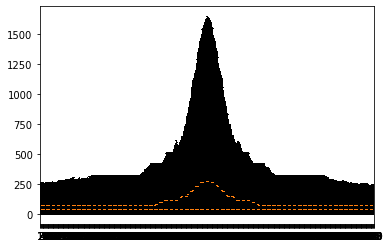

In [7]:
pos_sig_mat = get_signal(pybedtools.BedTool(args.out_dir + args.cell_name + "." + "positive.bed"), chromAcc_bw)
neg_sig_mat = get_signal(pybedtools.BedTool(args.out_dir + args.cell_name + "." + "negative.bed"), chromAcc_bw)
#signal_mat = np.vstack((pos_sig_mat, neg_sig_mat))
#print(signal_mat.shape)
np.savetxt(args.out_dir + args.cell_name+"."+"ATAC"+".pos.tsv", pos_sig_mat, fmt='%s', delimiter='\t')
np.savetxt(args.out_dir + args.cell_name+"."+"ATAC"+".neg.tsv", neg_sig_mat, fmt='%s', delimiter='\t')
plt.boxplot(pos_sig_mat, showfliers=False);
plt.boxplot(neg_sig_mat, showfliers=False);

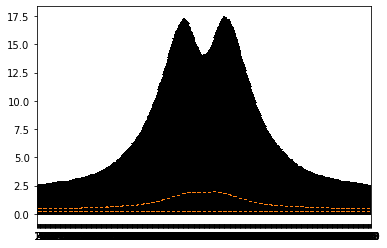

In [8]:
pos_sig_mat = get_signal(pybedtools.BedTool(args.out_dir + args.cell_name + "." + "positive.bed"), chip1_bw)
neg_sig_mat = get_signal(pybedtools.BedTool(args.out_dir + args.cell_name + "." + "negative.bed"), chip1_bw)
np.savetxt(args.out_dir + args.cell_name+"."+"H3K27ac"+".pos.tsv", pos_sig_mat, fmt='%s', delimiter='\t')
np.savetxt(args.out_dir + args.cell_name+"."+"H3K27ac"+".neg.tsv", neg_sig_mat, fmt='%s', delimiter='\t')
plt.boxplot(pos_sig_mat, showfliers=False);
plt.boxplot(neg_sig_mat, showfliers=False);

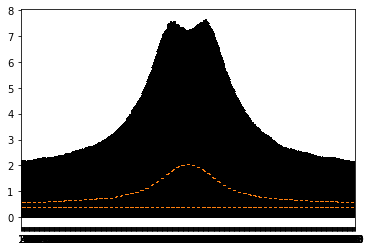

In [9]:
pos_sig_mat = get_signal(pybedtools.BedTool(args.out_dir + args.cell_name + "." + "positive.bed"), chip2_bw)
neg_sig_mat = get_signal(pybedtools.BedTool(args.out_dir + args.cell_name + "." + "negative.bed"), chip2_bw)
np.savetxt(args.out_dir + args.cell_name+"."+"H3K4me3"+".pos.tsv", pos_sig_mat, fmt='%s', delimiter='\t')
np.savetxt(args.out_dir + args.cell_name+"."+"H3K4me3"+".neg.tsv", neg_sig_mat, fmt='%s', delimiter='\t')
plt.boxplot(pos_sig_mat, showfliers=False);
plt.boxplot(neg_sig_mat, showfliers=False);

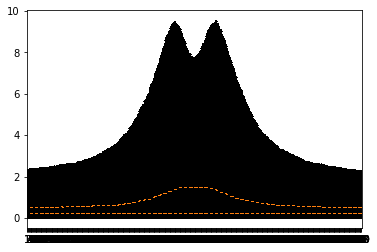

In [10]:
pos_sig_mat = get_signal(pybedtools.BedTool(args.out_dir + args.cell_name + "." + "positive.bed"), chip3_bw)
neg_sig_mat = get_signal(pybedtools.BedTool(args.out_dir + args.cell_name + "." + "negative.bed"), chip3_bw)
np.savetxt(args.out_dir + args.cell_name+"."+"H3K9ac"+".pos.tsv", pos_sig_mat, fmt='%s', delimiter='\t')
np.savetxt(args.out_dir + args.cell_name+"."+"H3K9ac"+".neg.tsv", neg_sig_mat, fmt='%s', delimiter='\t')
plt.boxplot(pos_sig_mat, showfliers=False);
plt.boxplot(neg_sig_mat, showfliers=False);

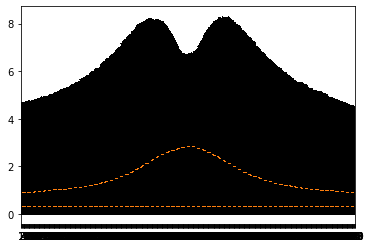

In [11]:
pos_sig_mat = get_signal(pybedtools.BedTool(args.out_dir + args.cell_name + "." + "positive.bed"), chip4_bw)
neg_sig_mat = get_signal(pybedtools.BedTool(args.out_dir + args.cell_name + "." + "negative.bed"), chip4_bw)
np.savetxt(args.out_dir + args.cell_name+"."+"H3K4me1"+".pos.tsv", pos_sig_mat, fmt='%s', delimiter='\t')
np.savetxt(args.out_dir + args.cell_name+"."+"H3K4me1"+".neg.tsv", neg_sig_mat, fmt='%s', delimiter='\t')
plt.boxplot(pos_sig_mat, showfliers=False);
plt.boxplot(neg_sig_mat, showfliers=False);